In [1]:
import pandas as pd
import numpy as np
from collections import defaultdict

data_dir = '/Users/unchitta/Research/data'

## Generate population totals used in ATUS

In [2]:
## p(g, c=(sex, race)) from PEP
#### NOTE: this is pop aged >= 15 ####

pep = pd.read_csv(f'{data_dir}/census/PEP/cc-est2019-alldata.csv', encoding="ISO-8859-1", dtype={'STATE':str,'COUNTY':str})
pep = pep.assign(FIPS = pep['STATE'] + pep['COUNTY'])
county_cbsa_cw = pd.read_csv(f'{data_dir}/census/clean/cbsa_county_delineation_mar_2020.csv', 
                            dtype={'county_fips':str, 'cbsa_code':str})
county_cbsa_cw.set_index('county_fips', inplace=True)
pep = pd.merge(pep, county_cbsa_cw[['cbsa_code']], how='left', left_on='FIPS', right_index=True)
sex_by_race_cols = {}
# NON-HISPANIC, BLACK ALONE
sex_by_race_cols['Male & Black~H'] = ['NHBA_MALE']      # nhba male
sex_by_race_cols['Female & Black~H'] = ['NHBA_FEMALE']    # nhba female
# NON-HISPANIC, NON-BLACK ALONE
nh_prefixes = ['NHIAC','NHAAC','NHNAC','NHWAC']
sex_by_race_cols['Male & Other'] = [f'{prefix}_MALE' for prefix in nh_prefixes]
sex_by_race_cols['Female & Other'] = [f'{prefix}_FEMALE' for prefix in nh_prefixes]
# HISPANIC, ANY RACE
# NOTE: Need to subtract `HBA_MALE` from `H_MALE`
sex_by_race_cols['Male & Hispanic'] = ['H_MALE']
sex_by_race_cols['Female & Hispanic'] = ['H_FEMALE']

for k,v in sex_by_race_cols.items():
    pep[k] = pep[v].sum(axis=1)
pep['Male & Hispanic'] = pep['Male & Hispanic'] - pep['HBA_MALE']
pep['Female & Hispanic'] = pep['Female & Hispanic'] - pep['HBA_FEMALE']
pep['MALE'] = pep[['Male & Black~H','Male & Other','Male & Hispanic']].sum(axis=1)
pep['FEMALE'] = pep[['Female & Black~H','Female & Other','Female & Hispanic']].sum(axis=1)

sex_by_race_colnames = list(sex_by_race_cols.keys())
cols_to_keep = ['cbsa_code','YEAR','AGEGRP','TOT_MALE','MALE','TOT_FEMALE','FEMALE'] + sex_by_race_colnames
pep = pep[cols_to_keep]
pep.dropna(inplace=True)
pep['cbsa_code'] = pep['cbsa_code'].astype(int)
pep = pep.query('YEAR >= 8 and AGEGRP >= 4')    # only keep rows where year is between 2015 and 2019
#pep = pep.query('YEAR >= 8')    # only keep rows where year is between 2015 and 2019
pep_gb = pep\
    .groupby(['cbsa_code','YEAR','AGEGRP'], as_index=False).agg('sum')\
    .groupby(['cbsa_code','AGEGRP'], as_index=False).agg('mean')

sex_by_race = pep_gb.groupby('cbsa_code')[sex_by_race_colnames].sum()
sex_by_race['Total'] = sex_by_race.sum(axis=1)
sex_by_race



## p(g, c=(sex, edu)) from ACS

acs_b15001 = pd.read_csv(f'{data_dir}/census/ACS/acs2019_5yr_B15001_sex_by_edu_metro/acs2019_5yr_B15001_sex_by_edu_metro.csv')
acs_b15001 = acs_b15001.assign(geoid=acs_b15001['geoid'].apply(lambda x: int(x[-5:]))).set_index('geoid')

cols = defaultdict(list)
for i in range(0,5):
    cols['Male & HS+'].extend([f'B150010{(6+8*i)+n:02d}' for n in range(0,5)])       # MALE_HS
    cols['Male & No HS'].extend([f'B150010{(4+8*i)+n:02d}' for n in range(0,2)])       # MALE_NOHS
    cols['Female & HS+'].extend([f'B150010{(47+8*i)+n:02d}' for n in range(0,5)])      # FEMALE_HS
    cols['Female & No HS'].extend([f'B150010{(45+8*i)+n:02d}' for n in range(0,2)])      # FEMALE_NOHS

for k,v in cols.items():
    acs_b15001[k] = acs_b15001[v].sum(axis=1)  # divide by 2 for refday

sex_by_edu = acs_b15001[cols.keys()]


## p(g, c=(sex, age)) from PEP

def pep_age_group(x):
    if x<23:
        return 1    # 1=younger than 23 age group
    elif x in range(23,60):
        return 2    # 2=between 23 and 59 age group
    else:
        return 3    # 3=60 and older

sex_by_age = pd.merge(
    pd.merge(
        pep_gb.query('AGEGRP<=5').groupby('cbsa_code').agg(
            SEX1_AGE1=('MALE', 'sum'), 
            SEX2_AGE1=('FEMALE', 'sum')),
        pep_gb.query('AGEGRP>5 and AGEGRP<=12').groupby('cbsa_code').agg(
            SEX1_AGE2=('MALE', 'sum'),  
            SEX2_AGE2=('FEMALE','sum')),
        on='cbsa_code'),
    pep_gb.query('AGEGRP>=13').groupby('cbsa_code').agg(
        SEX1_AGE3=('MALE', 'sum'), 
        SEX2_AGE3=('FEMALE', 'sum')),
    on='cbsa_code'
)

sex_by_age.rename(columns={
    'SEX1_AGE1':'Male & Age<23',
    'SEX1_AGE2':'Male & 23<=Age<60',
    'SEX1_AGE3':'Male & Age>=60',
    'SEX2_AGE1':'Female & Age<23',
    'SEX2_AGE2':'Female & 23<=Age<60',
    'SEX2_AGE3':'Female & Age>=60'
}, inplace=True)

# since the ACS data is only for population aged >= 18 and PEP includes population aged between 15-17,
# the ACS totals in each CBSA usually underestimates the PEP totals
# Given the average age of high school graduation of 18 years old,
# assume that individuals aged between 15-17 have not finished high school.
# With this assumption, assign differences between PEP and ACS to the EDU=No HS columns
# in order to make all the totals consistent

diff = pd.Series(sex_by_race.sum(axis=1) - sex_by_edu.sum(axis=1)) / 2
diff = diff.apply(lambda x: 0 if x < 0 else round(x,2))
for col in ['Male & No HS','Female & No HS']:
    sex_by_edu.loc[:, col] = sex_by_edu.loc[:, col] + diff

/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [3]:
sex_by_race

Male & Black~H  Female & Black~H  Male & Other  Female & Other  \
cbsa_code                                                                   
10100               320.8             244.4       16144.0         17042.8   
10140               618.2             152.8       28432.8         27912.0   
10180              6131.8            3869.8       48011.0         50528.0   
10220               398.2             321.8       14426.4         15782.0   
10300              1786.4             427.4       36615.8         37491.4   
...                   ...               ...           ...             ...   
49660             21714.2           23637.8      191396.6        205048.2   
49700              2071.4            1600.8       48105.2         49905.0   
49740              2386.6             976.4       33692.8         30859.6   
49780              1420.2            1195.2       32087.8         35187.0   
49820                14.4               8.6         342.8           342.8   

           Male & Hispanic  Female & Hispanic     Total  
cbsa_code                                                
10100                449.6              317.2   34518.8  
10140               2504.2             2009.8   61629.8  
10180              14778.0            13518.0  136836.6  
10220                727.8              581.0   32237.2  
10300               2829.0             2721.0   81871.0  
...                    ...                ...       ...  
49660               6784.8             5309.4  453891.0  
49700              17785.6            16958.0  136426.0  
49740              48989.6            48166.4  165071.4  
49780                301.6              304.0   70495.8  
49820               4605.2             4915.8   10229.6  

[927 rows x 7 columns]

In [4]:
sex_by_age

Male & Age<23  Female & Age<23  Male & 23<=Age<60  \
cbsa_code                                                      
10100             2770.8           2883.4             9534.2   
10140             4270.6           3750.8            16885.0   
10180            15007.2          13946.2            38279.8   
10220             3073.6           3097.6             8635.4   
10300             6989.2           6123.4            22628.2   
...                  ...              ...                ...   
49660            34863.2          32517.0           116214.4   
49700            12694.8          11324.6            39332.8   
49740            18493.6          14254.8            43296.2   
49780             5813.8           5636.8            18686.8   
49820             1133.8           1087.8             2689.2   

           Female & 23<=Age<60  Male & Age>=60  Female & Age>=60  
cbsa_code                                                         
10100                   9137.8          4609.4            5583.2  
10140                  15154.6         10399.6           11169.2  
10180                  34871.4         15633.8           19098.2  
10220                   8770.2          3843.4            4817.0  
10300                  20927.8         11613.8           13588.6  
...                        ...             ...               ...  
49660                 116215.4         68818.0           85263.0  
49700                  38991.4         15934.6           18147.8  
49740                  40282.0         23279.2           25465.6  
49780                  19416.8          9309.0           11632.6  
49820                   2920.4          1139.4            1259.0  

[927 rows x 6 columns]

In [5]:
sex_by_edu

Male & HS+  Male & No HS  Female & HS+  Female & No HS
geoid                                                        
10100       14952       19304.3         15193         19588.3
10140       26197       36193.3         25358         35511.3
10180       56814       80600.1         57575         78684.1
10220       12536       19234.2         13654         19050.2
10300       34759       47249.5         35367         46366.5
...           ...           ...           ...             ...
49660      185250      261242.5        201354        259935.5
49700       50110       85965.0         51746         85031.0
49740       60031      107657.4         56689        105765.4
49780       27300       41689.3         31225         40777.3
49820        2992        7055.6          3126          7285.6

[938 rows x 4 columns]

## Tidy Pew data

In [6]:
pew = pd.read_csv(f'{data_dir}/pew/Pew-Social-Trends-Data-Mobility-12-2009/social_trends_dataset.csv', dtype={'GTCBSA':str})
pew = pew[['GTCBSA','sex','age','Education','racethn','weight','Family Available']].copy()
pew.rename(columns={'Education':'edu', 'racethn':'race', 'Family Available':'family'}, inplace=True)
pew = pew.dropna()

# recategorize characteristic variables
pew['edu'] = pew['edu'].apply(lambda x : 'No HS' if x=='lt_highschool' else 'HS+')
pew['race'] = pew['race'].apply(lambda x: 'Other' if x not in ['Black~H','Hispanic'] else x)
pew['age'] = pew['age'].apply(lambda x: 97 if x == '97 or older' else int(x))
def age_class(x):
    if x < 23:
        return 'Age<23'
    elif x < 60:
        return '23<=Age<60'
    else:
        return 'Age>=60'
pew['age_group'] = pew['age'].apply(age_class)
pew.drop(columns=['age'], inplace=True)

pew = pew.set_index('GTCBSA')
pew = pew[['sex','race','edu','age_group','weight','family']]

# concat characteristic to make 2d c's
c = [['sex','race'], ['sex', 'edu'], ['sex', 'age_group']]
i = 1
for c_vec in c:
    pew[f'c{i}'] = pew[c_vec].apply(lambda x : x[0] + ' & ' + x[1], axis=1)
    i+=1

pew['pew_weighted_family'] = pew['weight'] * pew['family']
pew

sex     race    edu   age_group    weight  family  \
GTCBSA                                                         
14860   Female    Other    HS+  23<=Age<60  3.547619       0   
13820   Female  Black~H    HS+  23<=Age<60  2.250000       1   
13820   Female    Other  No HS     Age>=60  2.523810       1   
13820   Female    Other    HS+     Age>=60  3.333333       1   
42660   Female    Other    HS+  23<=Age<60  5.119048       0   
...        ...      ...    ...         ...       ...     ...   
35620   Female    Other    HS+     Age>=60  1.018868       1   
35620     Male    Other    HS+  23<=Age<60  1.687500       1   
35620     Male    Other    HS+     Age>=60  3.187500       0   
14460     Male    Other    HS+     Age>=60  2.245283       1   
29620     Male    Other    HS+  23<=Age<60  1.754717       1   

                      c1              c2                   c3  \
GTCBSA                                                          
14860     Female & Other    Female & HS+  Female & 23<=Age<60   
13820   Female & Black~H    Female & HS+  Female & 23<=Age<60   
13820     Female & Other  Female & No HS     Female & Age>=60   
13820     Female & Other    Female & HS+     Female & Age>=60   
42660     Female & Other    Female & HS+  Female & 23<=Age<60   
...                  ...             ...                  ...   
35620     Female & Other    Female & HS+     Female & Age>=60   
35620       Male & Other      Male & HS+    Male & 23<=Age<60   
35620       Male & Other      Male & HS+       Male & Age>=60   
14460       Male & Other      Male & HS+       Male & Age>=60   
29620       Male & Other      Male & HS+    Male & 23<=Age<60   

        pew_weighted_family  
GTCBSA                       
14860              0.000000  
13820              2.250000  
13820              2.523810  
13820              3.333333  
42660              0.000000  
...                     ...  
35620              1.018868  
35620              1.687500  
35620              0.000000  
14460              2.245283  
29620              1.754717  

[1996 rows x 10 columns]

## Ex: calculate phi(g) and tilde{phi(g)} using atus weights

In [7]:
#### phi_g

# join sex_by_race to get p(g)
sex_by_race_copy = sex_by_race.copy().reset_index()
sex_by_race_copy['cbsa_code'] = sex_by_race_copy['cbsa_code'].astype(str)
sex_by_race_copy.set_index('cbsa_code', inplace=True)
phi_g_atus = pd.merge(pew, sex_by_race_copy[['Total']], left_on='GTCBSA', right_index=True)

# join count of s(g,c), the number of pew respondents in g with c, to dataframe of respondents
phi_g_atus = pd.merge(
    phi_g_atus, 
    pew.groupby(['GTCBSA','c1']).agg(s_gc=('family','count')), 
    left_on=['GTCBSA','c1'], right_on=['GTCBSA','c1']).reset_index()

# calculate weight per pew respondent based on g, c, s(g,c) from pew and p(g,c) from atus
phi_g_atus['weight_atus'] = phi_g_atus[['GTCBSA','c1','s_gc']].apply(lambda x: sex_by_race_copy.loc[x[0],x[1]] / x[2], axis=1)

# calculate phi_g
phi_g_atus['weighted_fam'] = phi_g_atus['weight_atus'] * phi_g_atus['family']
phi_g_atus = phi_g_atus.groupby('GTCBSA').agg(sum_fam=('weighted_fam','sum'), p_g=('weight_atus','sum'), count=('Total','count'))
phi_g_atus['phi_g'] = phi_g_atus['sum_fam'] / phi_g_atus['p_g']

phi_g_atus


sum_fam       p_g  count     phi_g
GTCBSA                                     
10140    28432.8   28432.8      1  1.000000
10220    15782.0   15782.0      1  1.000000
10420   248214.8  511961.2      2  0.484831
10460    15943.4   15943.4      1  1.000000
10500    60410.6   60410.6      2  1.000000
...          ...       ...    ...       ...
49620   167673.6  167673.6      2  1.000000
49660   205048.2  205048.2      4  1.000000
49700    48105.2   48105.2      2  1.000000
49740    48989.6   79849.2      2  0.613526
49780    67274.8   67274.8      2  1.000000

[482 rows x 4 columns]

In [8]:
# phi(c) is needed for tilde{phi(g)}

# non-weighted version of phi_c
#phi_c = [pew.groupby(f'c{i}').agg(count=('family','count'), family=('family','sum')) for i in range(1,4)]

# pew-weighted version of phi_c
phi_c = [pew.groupby(f'c{i}').agg(count=('weight','sum'), family=('pew_weighted_family','sum')) for i in range(1,4)]

### to get atus-weighted version of phi_c, repeat similar to the above cell


for df in phi_c:
    df['phi_c'] = df['family'] / df['count']

In [9]:
phi_c[0]

count       family     phi_c
c1                                                   
Female & Black~H    393.867419   315.041554  0.799867
Female & Hispanic   349.365398   255.166274  0.730371
Female & Other     2005.412062  1613.448675  0.804547
Male & Black~H      234.877864   199.383872  0.848883
Male & Hispanic     367.645946   293.904144  0.799422
Male & Other       1950.286164  1596.457210  0.818576

In [10]:
# compute phi_g_tilde based on atus weights

phi_g_tilde = pd.merge(sex_by_race_copy, phi_g_atus[['phi_g']], left_index=True, right_index=True)

c_cols = phi_g_tilde.columns[:-2]
for col in c_cols:
    phi_g_tilde[col] = phi_g_tilde[col] * phi_c[0].loc[col,'phi_c']
phi_g_tilde['phi_g_tilde'] = phi_g_tilde[c_cols].sum(axis=1)
phi_g_tilde['phi_g_tilde'] = phi_g_tilde['phi_g_tilde'] / phi_g_tilde['Total']

phi_g_tilde

Male & Black~H  Female & Black~H   Male & Other  Female & Other  \
10140      524.779593        122.219679   23274.404247    22456.521661   
10220      338.025290        257.397203   11809.103058    12697.364032   
10420    26163.598847      29552.526396  203182.648045   212196.429659   
10460      951.428289        589.022065   14196.234036    12827.217951   
10500    23528.495621      27641.804086   21162.314765    22487.738093   
...               ...               ...            ...             ...   
49620     8254.200672       7534.267301  129294.060059   133840.450736   
49660    18432.819555      18907.096378  156672.640048   164970.956753   
49700     1758.376658       1280.427107   39377.756366    40150.928400   
49740     2025.944642        780.990147   27580.113370    24828.005011   
49780     1205.583919        956.001049   26266.299084    28309.602597   

       Male & Hispanic  Female & Hispanic     Total     phi_g  phi_g_tilde  
10140      2001.911803        1467.899169   61629.8  1.000000     0.808825  
10220       581.819108         424.345416   32237.2  1.000000     0.809874  
10420      3771.511662        3515.274504  589260.0  0.484831     0.811835  
10460      7363.473212        6628.552938   53429.8  1.000000     0.796483  
10500      1022.300461         743.371367  118375.0  1.000000     0.815933  
...                ...                ...       ...       ...          ...  
49620      7945.771973        6984.973873  362951.0  1.000000     0.809624  
49660      5423.916301        3877.830553  453891.0  1.000000     0.811396  
49700     14218.194459       12385.627476  136426.0  1.000000     0.800224  
49740     39163.348960       35179.330538  165071.4  0.613526     0.784859  
49780       241.105583         222.032713   70495.8  1.000000     0.811405  

[482 rows x 9 columns]

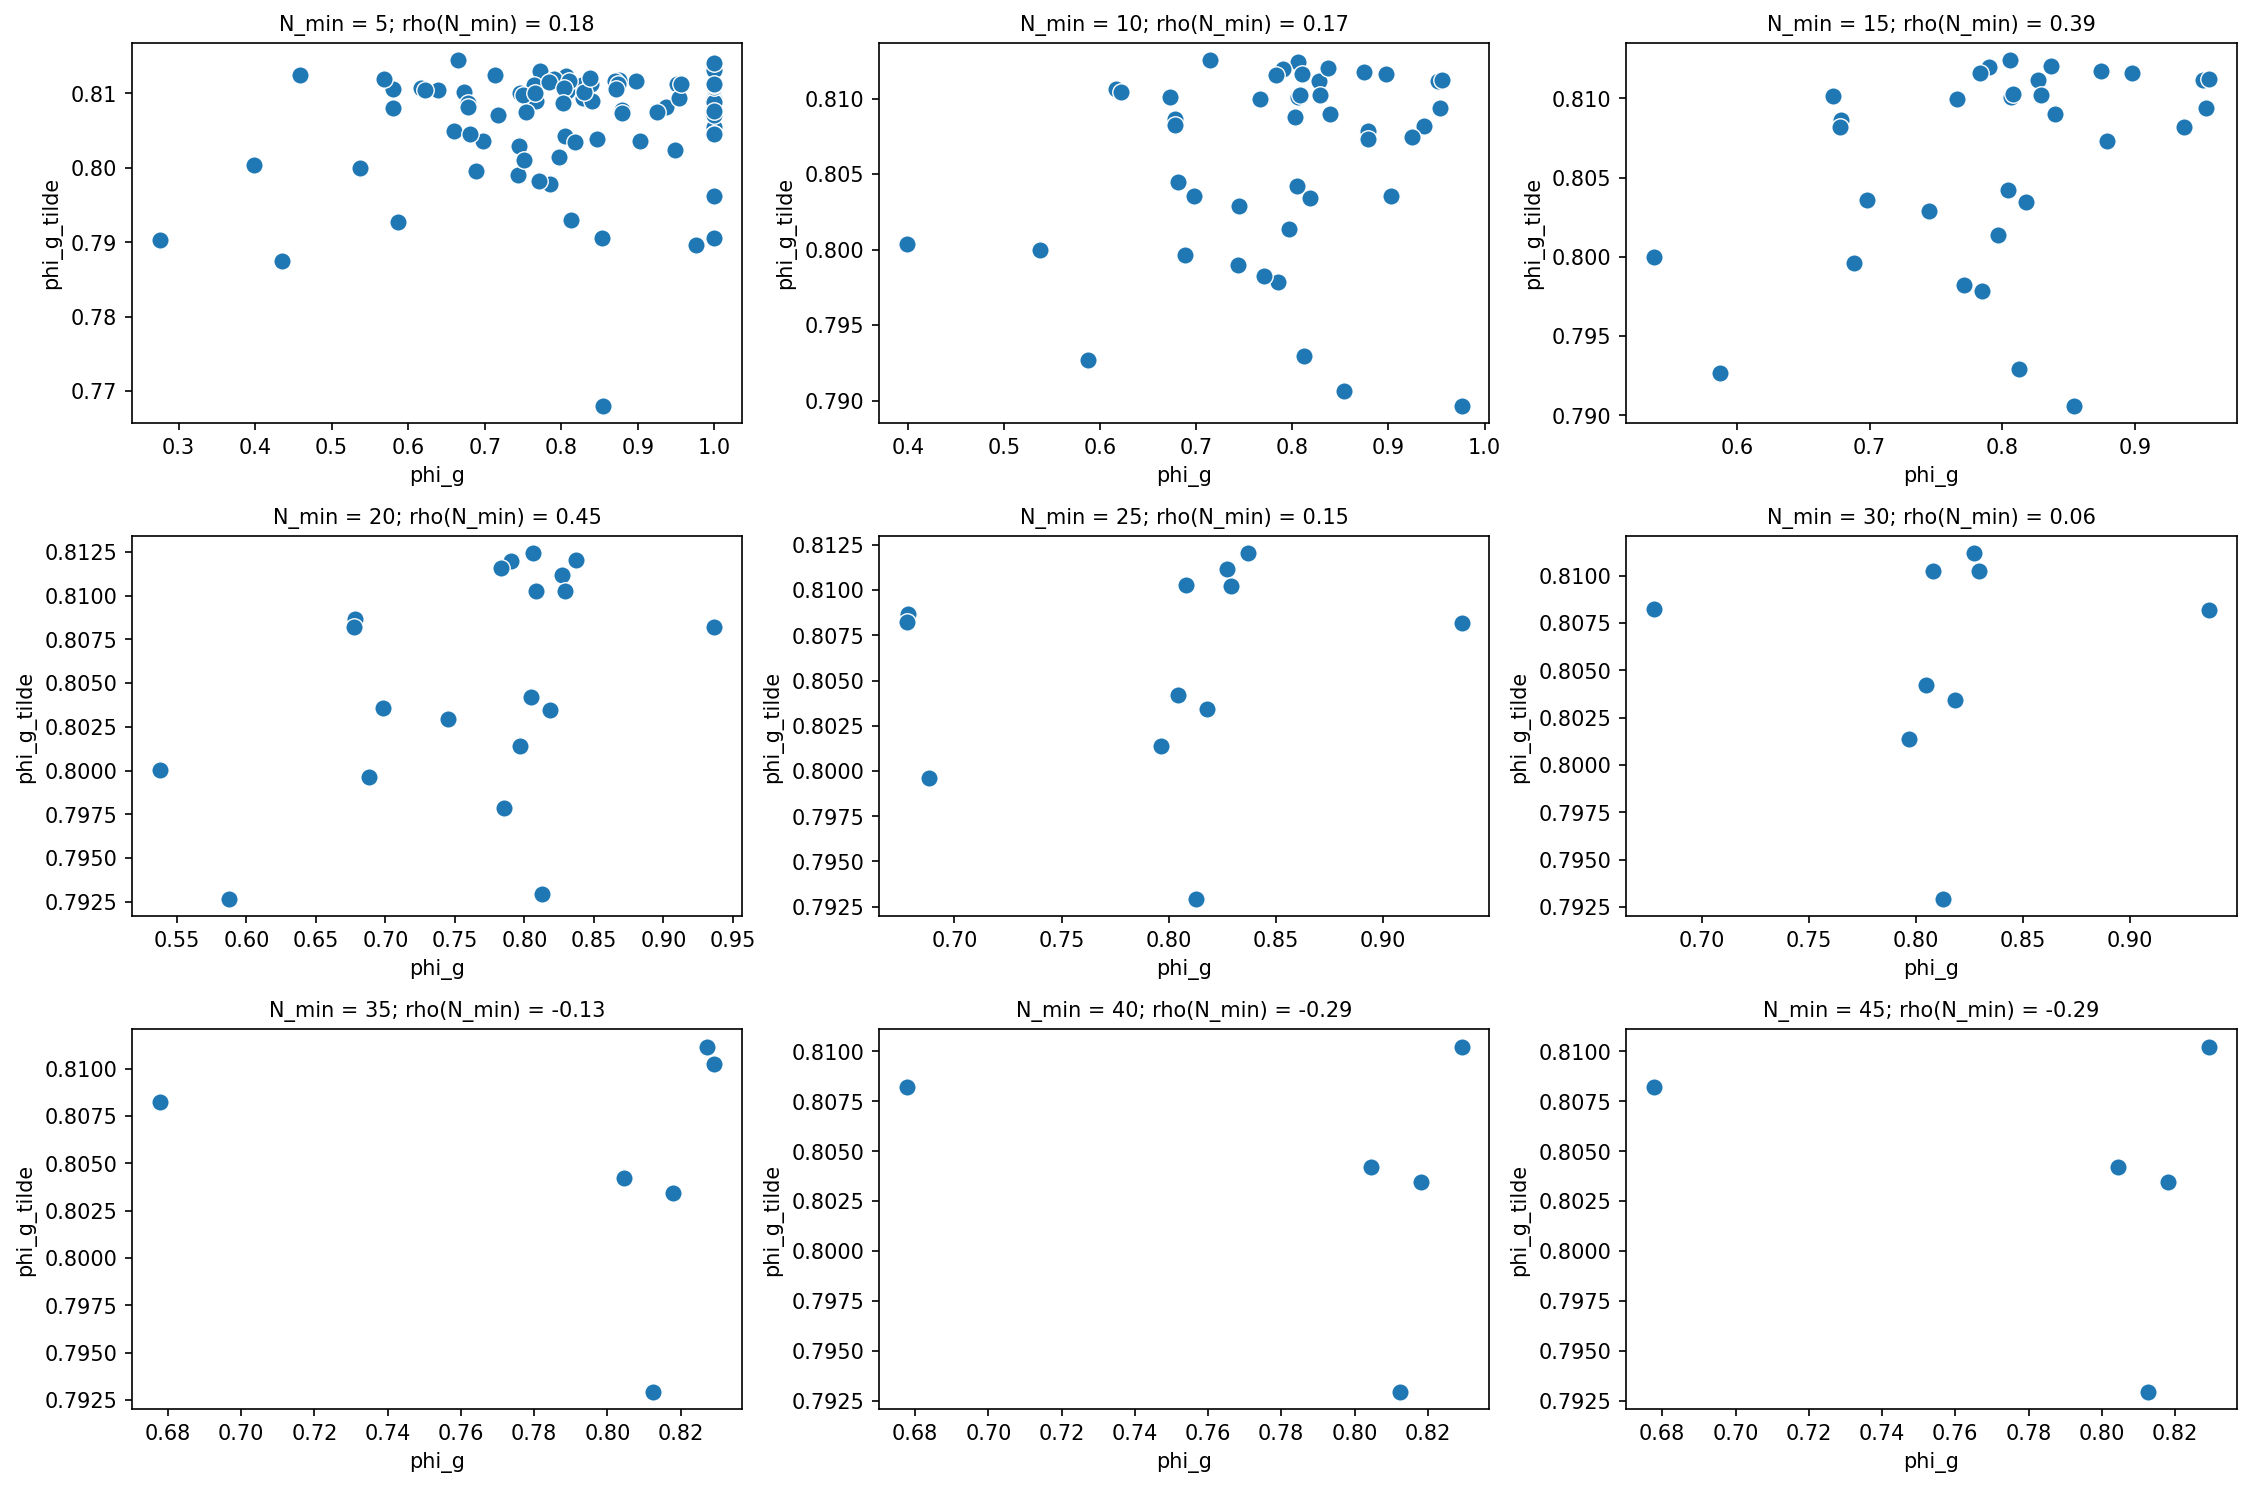

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

i=0; j=0
fig, ax = plt.subplots(3,3, figsize=(15,10), dpi=150)

for n in range(5,46,5):
    phi_g_tilde = pd.merge(sex_by_race_copy, phi_g_atus.query(f'count >= {n}')[['phi_g']], left_index=True, right_index=True)

    c_cols = phi_g_tilde.columns[:-2]
    for col in c_cols:
        phi_g_tilde[col] = phi_g_tilde[col] * phi_c[0].loc[col,'phi_c']
    phi_g_tilde['phi_g_tilde'] = phi_g_tilde[c_cols].sum(axis=1)
    phi_g_tilde['phi_g_tilde'] = phi_g_tilde['phi_g_tilde'] / phi_g_tilde['Total']

    corr = phi_g_tilde['phi_g'].corr(phi_g_tilde['phi_g_tilde'])
    sns.scatterplot(x='phi_g',y='phi_g_tilde',data=phi_g_tilde, s=70, ax=ax[i,j])
    ax[i,j].set_title(f'N_min = {n}; rho(N_min) = {np.round(corr,2)}', fontsize='medium')
    j+=1
    if j==3:
        i+=1
        j=0
fig.tight_layout(pad=1)
plt.show()